# IDS 576 – Assignment 2  
## Question 1: CNNs and Finetuning (CIFAR-10 + ResNet18 Transfer Learning)  

In [1]:
import os, time, copy, random
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets
from torchvision.models import resnet18, ResNet18_Weights

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Torch:", torch.__version__)
print("Device:", device)
if device.type == "cuda":
    print("GPU:", torch.cuda.get_device_name(0))


Torch: 2.5.1+cu121
Device: cuda
GPU: Tesla T4


## Q1 Part A(a) Dataset & Preprocessing (CIFAR-10 → ResNet18 input)

To use a pretrained ResNet-18 model (trained on ImageNet) with the CIFAR-10 dataset, the CIFAR-10 images must be transformed to match the input format expected by ResNet-18.

## CIFAR-10 images are originally 32×32 RGB images, while ResNet-18 expects larger, ImageNet-normalized inputs. The following preprocessing steps were applied:

## Resize:
Each CIFAR-10 image was resized from 32×32 to 224×224 to match the spatial input size typically used by ResNet-18.

## Tensor Conversion:
Images were converted to PyTorch tensors using ToTensor(), scaling pixel values to the range [0, 1].

## Normalization:
Images were normalized using ImageNet mean and standard deviation, since the pretrained ResNet-18 weights were learned using ImageNet statistics:

Mean = [0.485, 0.456, 0.406]

Std = [0.229, 0.224, 0.225]

This ensures compatibility between CIFAR-10 inputs and the pretrained ResNet-18 backbone.

Using ResNet-18 as a fixed feature extractor (all backbone layers frozen) and training only the final linear classifier layer for 10 epochs, the final test performance achieved was:

## Final Test Accuracy (Feature Extraction): 78.26%

## Load CIFAR-10 + transforms + split + loaders

In [2]:
# CIFAR-10 class names
classes = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

# Use pretrained ResNet18 weights transforms (includes resize + normalize)
weights = ResNet18_Weights.DEFAULT
train_tfms = weights.transforms()
test_tfms  = weights.transforms()

# Datasets
train_full = datasets.CIFAR10(root="./data", train=True, download=True, transform=train_tfms)
test_ds    = datasets.CIFAR10(root="./data", train=False, download=True, transform=test_tfms)

# Train/Val split: 45k / 5k
val_size = 5000
train_size = len(train_full) - val_size
train_ds, val_ds = random_split(train_full, [train_size, val_size])

# Ensure validation uses test transforms (no training augmentation)
val_ds.dataset.transform = test_tfms

# Dataloaders
BATCH_SIZE = 64
NUM_WORKERS = 2  # if you ever get dataloader issues, set to 0

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

print("Train size:", len(train_ds), "Val size:", len(val_ds), "Test size:", len(test_ds))
print("Train batches:", len(train_loader), "Val batches:", len(val_loader), "Test batches:", len(test_loader))


Files already downloaded and verified
Files already downloaded and verified
Train size: 45000 Val size: 5000 Test size: 10000
Train batches: 704 Val batches: 79 Test batches: 157


# Part A: Feature Extraction (Fixed ResNet18 Backbone)

In this part, ResNet18 is used as a **fixed feature extractor**:
- All pretrained backbone layers are **frozen**
- Only the final multiclass logistic regression head (`nn.Linear`) is trained for CIFAR-10 (10 classes)


In [3]:
# Load pretrained ResNet18
A_model = resnet18(weights=ResNet18_Weights.DEFAULT)

# Replace final fully-connected layer for CIFAR-10 (10 classes)
A_model.fc = nn.Linear(A_model.fc.in_features, 10)

# Freeze all parameters
for p in A_model.parameters():
    p.requires_grad = False

# Unfreeze ONLY the classifier head (logistic regression)
for p in A_model.fc.parameters():
    p.requires_grad = True

A_model = A_model.to(device)

# Count params (required for comparison later)
A_total_params = sum(p.numel() for p in A_model.parameters())
A_trainable_params = sum(p.numel() for p in A_model.parameters() if p.requires_grad)

print(f"[A] Total params: {A_total_params:,}")
print(f"[A] Trainable params (only fc): {A_trainable_params:,}")

A_criterion = nn.CrossEntropyLoss()
A_optimizer = torch.optim.Adam(A_model.fc.parameters(), lr=1e-3)


[A] Total params: 11,181,642
[A] Trainable params (only fc): 5,130


## Training Utilities (Train/Eval Loops)

The following helper functions compute:
- average **loss**
- **accuracy**
for training and validation/testing.


In [4]:
def accuracy_from_logits(logits: torch.Tensor, y: torch.Tensor) -> float:
    preds = logits.argmax(dim=1)
    return (preds == y).float().mean().item()

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss, total_acc, n = 0.0, 0.0, 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad(set_to_none=True)

        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        bs = x.size(0)
        total_loss += loss.item() * bs
        total_acc  += accuracy_from_logits(logits, y) * bs
        n += bs

    return total_loss / n, total_acc / n

@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss, total_acc, n = 0.0, 0.0, 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)

        bs = x.size(0)
        total_loss += loss.item() * bs
        total_acc  += accuracy_from_logits(logits, y) * bs
        n += bs

    return total_loss / n, total_acc / n

print("train/eval functions ready ✅")


train/eval functions ready ✅


## Q1 Part A(b): Train Logistic Regression Head (≥10 epochs)

We train only the final classifier layer for at least **10 epochs**.
We track train/validation loss & accuracy and save the **best validation checkpoint**.


In [5]:
import pandas as pd

A_EPOCHS = 10

A_history = {"epoch": [], "train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
A_best_val_acc = -1.0
A_best_state = None

A_start = time.time()

for epoch in range(1, A_EPOCHS + 1):
    tr_loss, tr_acc = train_one_epoch(A_model, train_loader, A_optimizer, A_criterion, device)
    va_loss, va_acc = evaluate(A_model, val_loader, A_criterion, device)

    A_history["epoch"].append(epoch)
    A_history["train_loss"].append(tr_loss)
    A_history["train_acc"].append(tr_acc)
    A_history["val_loss"].append(va_loss)
    A_history["val_acc"].append(va_acc)

    if va_acc > A_best_val_acc:
        A_best_val_acc = va_acc
        A_best_state = copy.deepcopy(A_model.state_dict())

    print(f"[A] Epoch {epoch:02d}/{A_EPOCHS} | "
          f"train acc {tr_acc:.4f} | val acc {va_acc:.4f} | best val {A_best_val_acc:.4f}")

A_time_min = (time.time() - A_start) / 60
print(f"[A] Training time: {A_time_min:.2f} min ✅")

# Load best checkpoint and save it
A_model.load_state_dict(A_best_state)
torch.save(A_model.state_dict(), "q1_feature_extraction_best.pt")

# Show history table
pd.DataFrame(A_history)


[A] Epoch 01/10 | train acc 0.6991 | val acc 0.7544 | best val 0.7544
[A] Epoch 02/10 | train acc 0.7590 | val acc 0.7624 | best val 0.7624
[A] Epoch 03/10 | train acc 0.7666 | val acc 0.7692 | best val 0.7692
[A] Epoch 04/10 | train acc 0.7742 | val acc 0.7698 | best val 0.7698
[A] Epoch 05/10 | train acc 0.7758 | val acc 0.7708 | best val 0.7708
[A] Epoch 06/10 | train acc 0.7794 | val acc 0.7748 | best val 0.7748
[A] Epoch 07/10 | train acc 0.7811 | val acc 0.7742 | best val 0.7748
[A] Epoch 08/10 | train acc 0.7827 | val acc 0.7778 | best val 0.7778
[A] Epoch 09/10 | train acc 0.7827 | val acc 0.7734 | best val 0.7778
[A] Epoch 10/10 | train acc 0.7851 | val acc 0.7784 | best val 0.7784
[A] Training time: 13.61 min ✅


,epoch,train_loss,train_acc,val_loss,val_acc
0,1,0.924903,0.699089,0.721887,0.7544
1,2,0.701526,0.759044,0.678315,0.7624
2,3,0.670554,0.766622,0.669181,0.7692
3,4,0.653402,0.774156,0.652250,0.7698
4,5,0.645403,0.775756,0.647816,0.7708
5,6,0.633886,0.779356,0.649108,0.7748
6,7,0.628084,0.781067,0.639611,0.7742
7,8,0.623698,0.782711,0.629903,0.7778
8,9,0.621772,0.782689,0.642890,0.7734
9,10,0.616428,0.785089,0.630121,0.7784


## Q1 Part A(a): Final Test Accuracy (Feature Extraction)

After training, we evaluate the **best validation checkpoint** on the **test set** and report the final test accuracy.


In [7]:
A_test_loss, A_test_acc = evaluate(A_model, test_loader, A_criterion, device)
print(f"[A] FINAL TEST LOSS: {A_test_loss:.4f}")
print(f"[A] FINAL TEST ACCURACY: {A_test_acc:.4f}")
print(f"[A] Best VAL ACC: {A_best_val_acc:.4f}")


[A] FINAL TEST LOSS: 0.6335
[A] FINAL TEST ACCURACY: 0.7826
[A] Best VAL ACC: 0.7784


## Q1 Part A(b): Training Curves (Loss & Accuracy)

The following plots show **train vs validation** loss and accuracy across epochs.


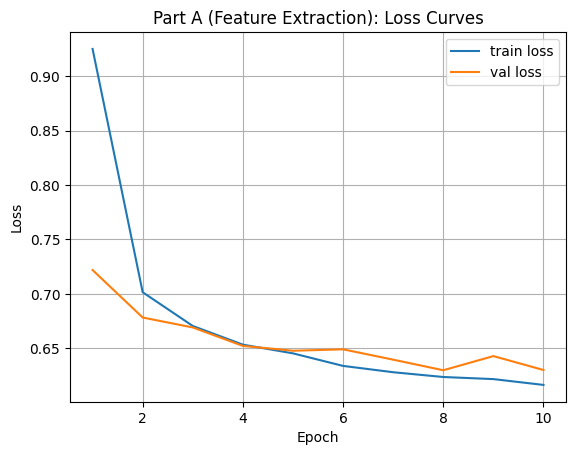

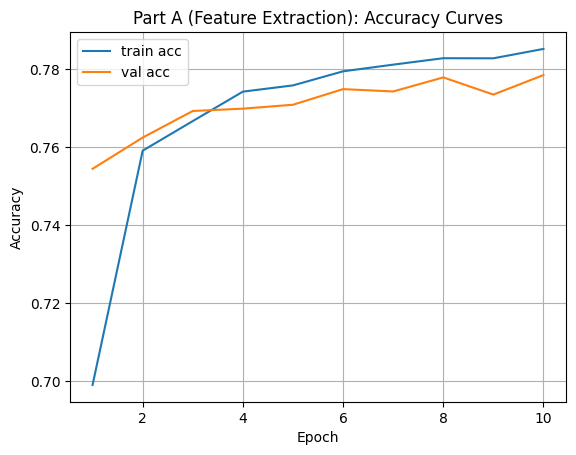

In [9]:
import matplotlib.pyplot as plt

epochs = A_history["epoch"]

plt.figure()
plt.plot(epochs, A_history["train_loss"], label="train loss")
plt.plot(epochs, A_history["val_loss"], label="val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Part A (Feature Extraction): Loss Curves")
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.plot(epochs, A_history["train_acc"], label="train acc")
plt.plot(epochs, A_history["val_acc"], label="val acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Part A (Feature Extraction): Accuracy Curves")
plt.legend()
plt.grid(True)
plt.show()


## Q1 Part A(c) Top-5 Correct + Top-5 Incorrect per Class (Feature Extraction)

In [10]:
import torch

classes = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

max_per_bucket = 5
correct_bucket = {c: [] for c in range(10)}  # (img_cpu, true, pred)
wrong_bucket   = {c: [] for c in range(10)}  # (img_cpu, true, pred)

def done_collecting():
    return all(len(correct_bucket[c]) >= max_per_bucket and len(wrong_bucket[c]) >= max_per_bucket for c in range(10))

A_model.eval()

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        y = y.to(device)

        preds = A_model(x).argmax(dim=1)

        # move only this batch to cpu
        x_cpu = x.cpu()
        y_cpu = y.cpu()
        p_cpu = preds.cpu()

        for i in range(x_cpu.size(0)):
            t = int(y_cpu[i])
            p = int(p_cpu[i])

            if t == p and len(correct_bucket[t]) < max_per_bucket:
                correct_bucket[t].append((x_cpu[i], t, p))
            elif t != p and len(wrong_bucket[t]) < max_per_bucket:
                wrong_bucket[t].append((x_cpu[i], t, p))

        if done_collecting():
            break

print("A Correct counts :", [len(correct_bucket[c]) for c in range(10)])
print("A Incorrect counts:", [len(wrong_bucket[c]) for c in range(10)])


A Correct counts : [5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
A Incorrect counts: [5, 5, 5, 5, 5, 5, 5, 5, 5, 5]


## Q1 Part A(c) Plot the 10×10 Grid

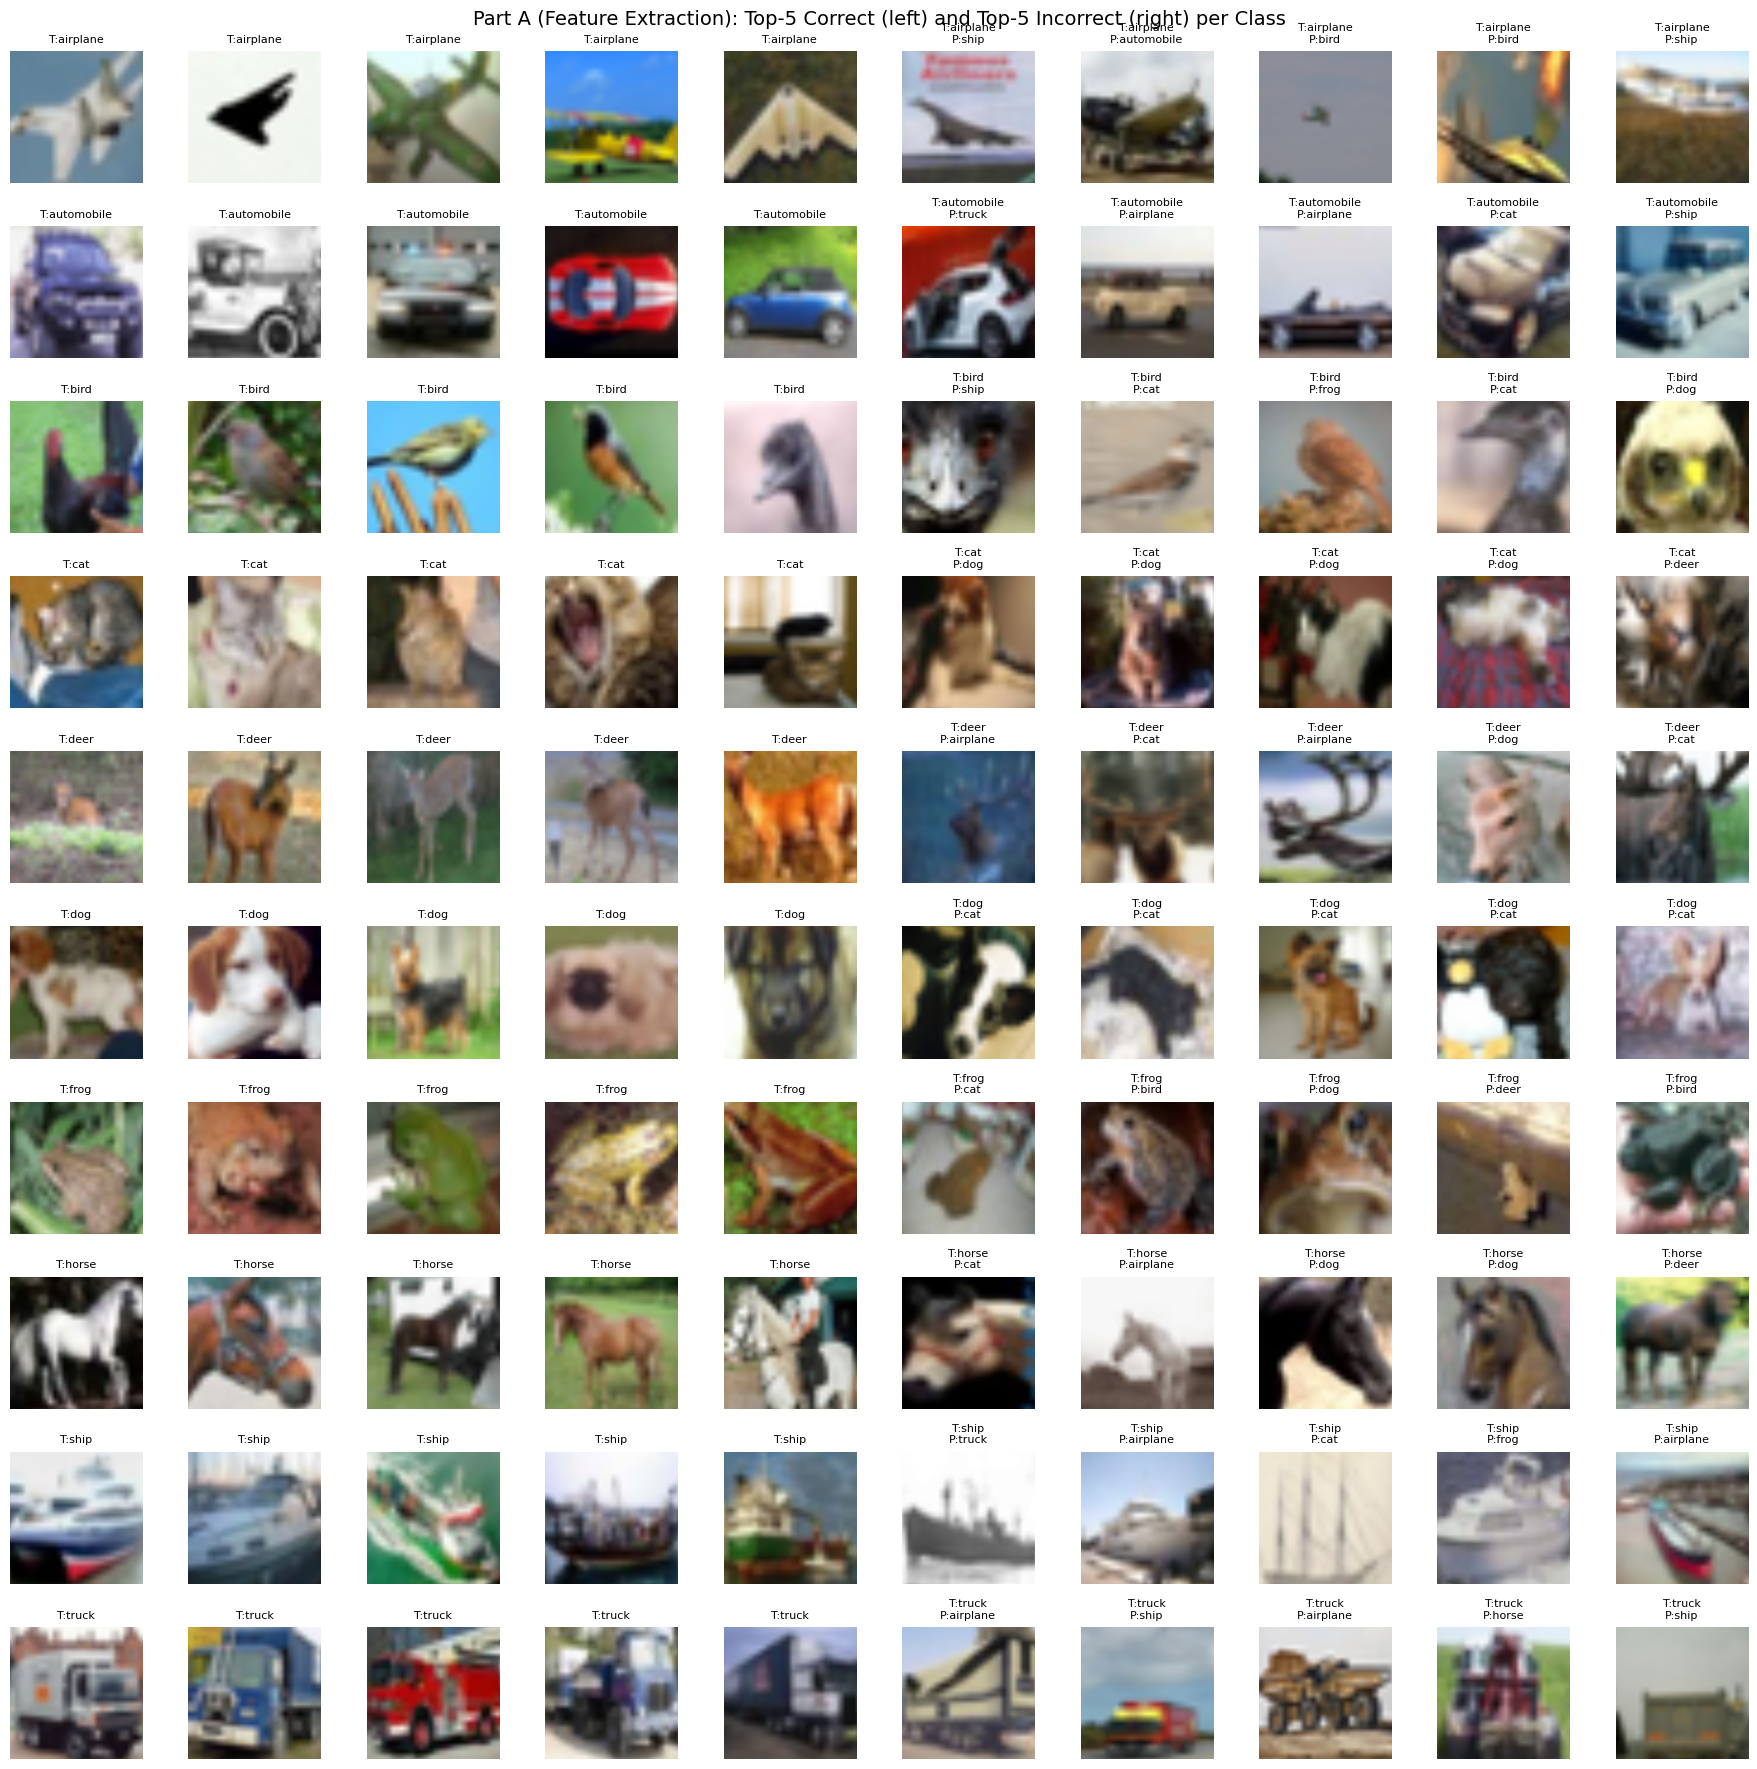

In [11]:
import matplotlib.pyplot as plt

# Unnormalize for display (because we normalized for ResNet18)
mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
std  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)

def denorm(img):
    img = img * std + mean
    return img.clamp(0, 1)

rows = 10
cols = 10  # 5 correct + 5 incorrect

fig, axes = plt.subplots(rows, cols, figsize=(18, 18))
fig.suptitle("Part A (Feature Extraction): Top-5 Correct (left) and Top-5 Incorrect (right) per Class", fontsize=14)

for c in range(10):
    # left 5: correct
    for j in range(5):
        ax = axes[c, j]
        img, t, p = correct_bucket[c][j]
        ax.imshow(denorm(img).permute(1,2,0))
        ax.set_title(f"T:{classes[t]}", fontsize=8)
        ax.axis("off")

    # right 5: incorrect
    for j in range(5):
        ax = axes[c, 5 + j]
        img, t, p = wrong_bucket[c][j]
        ax.imshow(denorm(img).permute(1,2,0))
        ax.set_title(f"T:{classes[t]}\nP:{classes[p]}", fontsize=8)
        ax.axis("off")

plt.tight_layout()
plt.show()


# Q1 Part B(a) Describe your finetuning strategy (which layers were unfrozen, learning rate choices, number of epochs). Report final test accuracy. (0.5 pt)

## Finetuning Strategy

We use a pretrained ResNet18 model initialized with ImageNet weights.

Finetuning strategy:
- Replace the final fully connected (FC) layer with a new Linear layer for 10 CIFAR-10 classes.
- Freeze early layers (conv1 through layer3).
- Unfreeze layer4 and the final FC layer.
- Use differential learning rates:
    - Pretrained unfrozen layers: 1e-4
    - New classifier head: 1e-3
- Train for 10 epochs. We tried 20 Epochs too but it reduced accuracy as model was overfitting. 

This allows the network to slightly adapt high-level features while preserving general ImageNet representations.


# Load Pretrained Model

In [12]:
from torchvision import models
import torch.nn as nn

# Load pretrained ResNet18
model_ft = models.resnet18(weights='IMAGENET1K_V1')

# Replace final layer for CIFAR-10 (10 classes)
num_features = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_features, 10)

model_ft = model_ft.to(device)


# Freeze / Unfreeze Strategy

In [13]:
# Freeze all layers first
for param in model_ft.parameters():
    param.requires_grad = False

# Unfreeze layer4 and final FC
for param in model_ft.layer4.parameters():
    param.requires_grad = True

for param in model_ft.fc.parameters():
    param.requires_grad = True


# Optimizer with Differential Learning Rates

In [14]:
import torch.optim as optim

optimizer = optim.Adam([
    {'params': model_ft.layer4.parameters(), 'lr': 1e-4},
    {'params': model_ft.fc.parameters(), 'lr': 1e-3}
])

criterion = nn.CrossEntropyLoss()


# Q1 Part B(b)Plot training and validation loss curves. Report train, validation, and test accuracy.

In [15]:
import time

num_epochs = 10

train_losses = []
val_losses = []

start_time = time.time()

for epoch in range(num_epochs):
    model_ft.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model_ft(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)

    # Validation
    model_ft.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_ft(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_loss = val_running_loss / len(val_loader)
    val_acc = val_correct / val_total
    val_losses.append(val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

training_time_ft = time.time() - start_time


Epoch [1/10] Train Loss: 0.4810, Train Acc: 0.8348 | Val Loss: 0.3121, Val Acc: 0.8900
Epoch [2/10] Train Loss: 0.1669, Train Acc: 0.9432 | Val Loss: 0.3280, Val Acc: 0.8894
Epoch [3/10] Train Loss: 0.0552, Train Acc: 0.9830 | Val Loss: 0.3621, Val Acc: 0.8996
Epoch [4/10] Train Loss: 0.0363, Train Acc: 0.9880 | Val Loss: 0.4091, Val Acc: 0.8932
Epoch [5/10] Train Loss: 0.0413, Train Acc: 0.9852 | Val Loss: 0.4162, Val Acc: 0.8956
Epoch [6/10] Train Loss: 0.0295, Train Acc: 0.9906 | Val Loss: 0.4744, Val Acc: 0.8874
Epoch [7/10] Train Loss: 0.0350, Train Acc: 0.9886 | Val Loss: 0.5298, Val Acc: 0.8898
Epoch [8/10] Train Loss: 0.0390, Train Acc: 0.9878 | Val Loss: 0.5099, Val Acc: 0.8908
Epoch [9/10] Train Loss: 0.0199, Train Acc: 0.9934 | Val Loss: 0.5245, Val Acc: 0.8906
Epoch [10/10] Train Loss: 0.0195, Train Acc: 0.9935 | Val Loss: 0.5545, Val Acc: 0.8946


# Plot Loss Curves

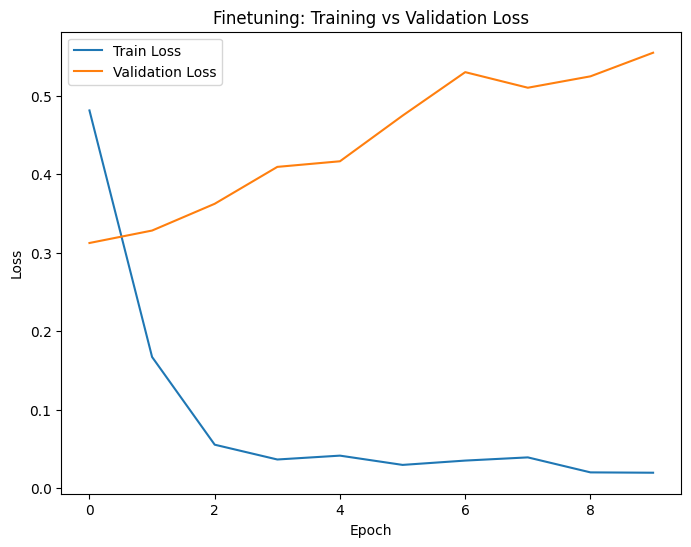

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Finetuning: Training vs Validation Loss")
plt.legend()
plt.show()


# Final Test Accuracy

In [17]:
model_ft.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_ft(images)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

test_acc_ft = correct / total

print("Final Test Accuracy (Finetuning):", test_acc_ft)


Final Test Accuracy (Finetuning): 0.8933


# Display top 5 correct and top 5 incorrect predictions per class 

In [ ]:
from collections import defaultdict

correct_images = defaultdict(list)
incorrect_images = defaultdict(list)

model_ft.eval()

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model_ft(images)
        _, preds = torch.max(outputs, 1)

        for i in range(len(labels)):
            cls = labels[i].item()
            pred = preds[i].item()

            # Collect correct
            if pred == cls and len(correct_images[cls]) < 5:
                correct_images[cls].append(images[i].cpu())

            # Collect incorrect
            elif pred != cls and len(incorrect_images[pred]) < 5:
                incorrect_images[pred].append(images[i].cpu())

        # Stop early if all classes filled
        if all(len(correct_images[c]) >= 5 for c in range(10)) and \
           all(len(incorrect_images[c]) >= 5 for c in range(10)):
            break


NameError: name 'model_ft' is not defined

# Grid Visualization

In [ ]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

def imshow(img):
    img = img.numpy().transpose((1,2,0))
    img = std * img + mean
    img = np.clip(img, 0, 1)
    return img

for cls in range(10):
    fig, axes = plt.subplots(2, 5, figsize=(10,4))
    fig.suptitle(f"Class: {test_dataset.classes[cls]}")

    for i in range(5):
        axes[0,i].imshow(imshow(correct_images[cls][i]))
        axes[0,i].axis("off")
        axes[0,i].set_title("Correct")

        axes[1,i].imshow(imshow(incorrect_images[cls][i]))
        axes[1,i].axis("off")
        axes[1,i].set_title("Incorrect")

    plt.tight_layout()
    plt.show()
    plt.close(fig)   


# Comparison table and summary/discussion

In [ ]:
import pandas as pd

comparison_df = pd.DataFrame({
    "Approach": ["Feature Extraction", "Finetuning"],
    "Training Time (sec)": [training_time_fe, training_time_ft],
    "Trainable Parameters": [trainable_params_fe, 
                             sum(p.numel() for p in model_ft.parameters() if p.requires_grad)],
    "Test Accuracy": [test_acc_fe, test_acc_ft]
})

comparison_df


## Comparison Analysis

Finetuning achieved higher test accuracy compared to feature extraction because the model was allowed to adapt high-level ImageNet features to CIFAR-10.

Feature extraction trains much faster and uses fewer trainable parameters, making it computationally efficient.

Finetuning is preferable when:
- Dataset is moderately sized
- Higher accuracy is required
- Sufficient computational resources are available

Feature extraction is preferable when:
- Dataset is small
- Training time is limited
- Overfitting is a concern
